In [178]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [179]:
# Data cleaning for Fama-French 3 factors portfolio and 25 portfolio on size and book to market value datasets

In this section: 
- (a) Evaluate the CAPM by reporting all the numbers above for the sample starting in 1947m01 and ending now.
- (b) Repeat, using the sample from 193201 to 196212

For part (a)
- (i) Do you see a pattern that high average returns are associated with high betas?
- (ii) Is the market premium ˆλ significant in the time series estimate?
- (iii) Is the CAPM rejected in the time-series estimate?
- (iv) How does the estimate of ˆλ and the ˆα in the cross sectional regression with a free constant differ from that of the time-series regression? Track down where this difference comes from there is an important lesson here. (Hint: look at the expected return vs beta graphs.)
- (v) How does the estimate of ˆλ when we force the intercept to zero and price the factors compare?

To evaluate the CAPM, just chi squared test would suffice. In the part D.

# a) Evaluate the CAPM for the data starting from 1947 onwards

In [180]:
# read the 25 portfolio on size and book to market value
file_path = '~/Desktop/AM Courses/25_Portfolios_5x5.CSV'
portfolio_24 = pd.read_csv(file_path)
portfolio_25 = portfolio_24.dropna()
portfolio_25['Date'] = portfolio_25['Date'].astype(str)
portfolio_25['Date'] = portfolio_25['Date'].str[:4] + '-' + portfolio_25['Date'].str[4:6]

In [181]:
portfolio_25 = portfolio_25.set_index('Date')

In [182]:
portfolio_25 = portfolio_25[portfolio_25.index >= "1947-01"]

- 

In [183]:
# read the Fama-French three factors model dataset
files_2 = '~/Desktop/AM Courses/F-F_Research_Data_Factors.CSV'
ff3raw = pd.read_csv(files_2)
ff3 = ff3raw.dropna()
ff3['Date'] = ff3['Date'].astype(str)
ff3['Date'] = ff3['Date'].str[:4] + '-' + ff3['Date'].str[4:6]

In [184]:
ff3 = ff3.set_index('Date')

In [185]:
ff3 = ff3[ff3.index >= "1947-01"]
chosen_columns = ['RF', 'Mkt-RF']
ff3 = ff3[chosen_columns]

In [186]:
ff3= pd.DataFrame(ff3)

- 

In [187]:
portfolio_25 = portfolio_25.sub(ff3['RF'], axis=0)

In [188]:
# Done with data cleaning!!!

-

Question a)
alpha: 0.08146747580174159
beta: 1.0801427322154626
    
          lambda  Standard_Error of lambda    t-stat   p-value
Mkt-RF  0.661457                  0.142257  4.649727  1

Test Stat: 15.07273840971547
    
Critical Value 37.814727903251179
P Value: 0.0017555322636835236
0.22768887103800975

lambda_0_hat:  1.3314874333151967
lambda_hat:  -0.495816420281745
RMSE: 0.1631792153471947
MAE: 0.1311977018202363
R^2 1st: 0.11352735717366258
R^2 2nd: 0.11352735717366269
R^2 3rd: 0.14898626288671624

lambda_0_hat	lambda_mkt
	1.331487	-0.495816

-

part a) compute alpha and beta

In [189]:
# Define columns and corresponding index in results.params and results.bse
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in portfolio_25.columns:
    # Ensure X (independent variables) is numeric
    X = sm.add_constant(ff3.iloc[:, 1:])
    Y = portfolio_25[name]

    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns:
        df1.loc[name, col] = float(results.params[idx])

# Print the resulting DataFrame
print("alpha:", df1['alpha'].mean())
print("beta:", df1['beta mkt'].mean())

alpha: 0.0818689377822116
beta: 1.0803663041234643


part b) estimated lambda

In [190]:
# Estimate lambda

# Initializing DataFrame
df_lambda = pd.DataFrame(columns=['lambda', 'Standard_Error of lambda', 't-stat', 'p-value'])

# Iterate over x in ff3 Dataset
for x in ff3.columns[1:]: # excluding the last column whcih is risk-free rate
    x_len = ff3[x]
    lambda_mean = x_len.mean()
    se_lambda = x_len.std() / np.sqrt(len(x_len))
    t_stat = lambda_mean / se_lambda
    
    # Getting the p-value
    # Assuming a two-tailed test, hence multiplying by 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(x_len)-1))
    
    # Assigning values to the DataFrame in one line
    df_lambda.loc[x] = [lambda_mean, se_lambda, t_stat, p_value]

# Print the resulting DataFrame
print(df_lambda.iloc[:1, ])

          lambda  Standard_Error of lambda    t-stat   p-value
Mkt-RF  0.664777                  0.142373  4.669258  0.000003


# part d) Chi^2 test, Test Stat, critical value, p value

In [191]:
# Define columns and corresponding index in results.params and results.bse
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in portfolio_25.columns:
    # Ensure X (independent variables) is numeric
    X = sm.add_constant(ff3['Mkt-RF'])
    Y = portfolio_25[name]

    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns:
        df1.loc[name, col] = float(results.params[idx])

# Number of observations
T = len(ff3['Mkt-RF'])

# vector f (lambdas)  1*1
f = np.array([df_lambda['lambda']['Mkt-RF']])

# covariance matrix f (1x1 for CAPM, which is variance in this case)
factor_cov_mat = np.array([[ff3['Mkt-RF'].var()]])

# alpha 25*1
alpha_vector = np.array(df1['alpha'])

# covariance matrix of residuals
residuals_df = pd.DataFrame(index=ff3.index, columns=df1.index.tolist())
for portfolio in residuals_df.columns:
    alpha = df1.loc[portfolio, 'alpha']
    beta_mkt = df1.loc[portfolio, 'beta mkt']
    
    expected_return = alpha + beta_mkt * ff3['Mkt-RF']
    residuals_df[portfolio] = portfolio_25[portfolio] - expected_return

residuals_cov_matrix = residuals_df.cov().values

# calculate test statistics
test_statistic = T * (1 / (1 + f.T @ np.linalg.inv(factor_cov_mat) @ f)) * \
                    alpha_vector.T @ np.linalg.inv(residuals_cov_matrix) @ alpha_vector

print(test_statistic)

114.42114253304545


In [192]:
# correct t stat to 113

In [193]:
# the 5% critical value
# N is the number of degrees of freedom
N=25
critical_value = stats.chi2.ppf(0.95, df=N)
print(critical_value)

# T is the computed test statistic
p_value = 1 - stats.chi2.cdf(test_statistic, df=N)
print(p_value)
# the root mean square
rms_alpha = np.sqrt(np.mean(df1['alpha']**2))
print(rms_alpha)

37.65248413348277
2.107203300738547e-13
0.22740959090831278


# Regressions with/without constants

In [194]:
# cross section with constant

#f1['alpha'] = pd.to_numeric(df1['alpha'], errors='coerce')
df1['beta mkt'] = pd.to_numeric(df1['beta mkt'], errors='coerce')

X = sm.add_constant(df1[['beta mkt']])
Y = portfolio_25.mean()
model = sm.OLS(Y, X)
results = model.fit()
results.params

# i)Estimates λˆ0 λˆ
lambda_0_hat = results.params[0]
lambda_mkt = results.params[1]
print('lambda_0_hat: ',lambda_0_hat)
print('lambda_hat: ',lambda_mkt)

cross_with_constant_lambda_df = pd.DataFrame({'lambda_0_hat':lambda_0_hat,'lambda_mkt':lambda_mkt},index=[0])

#ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_e = pd.DataFrame()
df_part_e['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_e['pricing_error_alpha'].abs().mean()
#sst = ((Y - Y.mean())**2).sum()
#ssr = ((df_part_e['pricing_error_alpha'])**2).sum()
ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_e['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot
#r2_1 = (X.dot(results.params)).var()/Y.var()
r2_2 = 1 - (df_part_e['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_e['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

lambda_0_hat:  1.322377454784267
lambda_hat:  -0.4834526202033337
RMSE: 0.16239024789909293
MAE: 0.12929514256629088
R^2 1st: 0.11136451102358957
R^2 2nd: 0.11136451102358957
R^2 3rd: 0.146909930582646


- 

In [195]:
# cross section without a constant
df1['beta mkt'] = pd.to_numeric(df1['beta mkt'], errors='coerce')

X = df1[['beta mkt']]  # Exclude the constant term
Y = portfolio_25.mean()

model = sm.OLS(Y, X)
results = model.fit()
results.params

# i) Estimates λˆ0 λˆ
lambda_mkt = results.params['beta mkt']
print('lambda_mkt: ', lambda_mkt)

cross_without_constant_lambda_df = pd.DataFrame({'lambda_mkt': lambda_mkt}, index=[0])

# ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_e = pd.DataFrame()
df_part_e['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_e['pricing_error_alpha'].abs().mean()
ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_e['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot
r2_2 = 1 - (df_part_e['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_e['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

lambda_mkt:  0.7259054494926614
RMSE: 0.21748758116833894
MAE: 0.15896590055747972
R^2 1st: -0.5939426457115653
R^2 2nd: -0.5855007118617643
R^2 3rd: -0.5301849398831029


# Plots

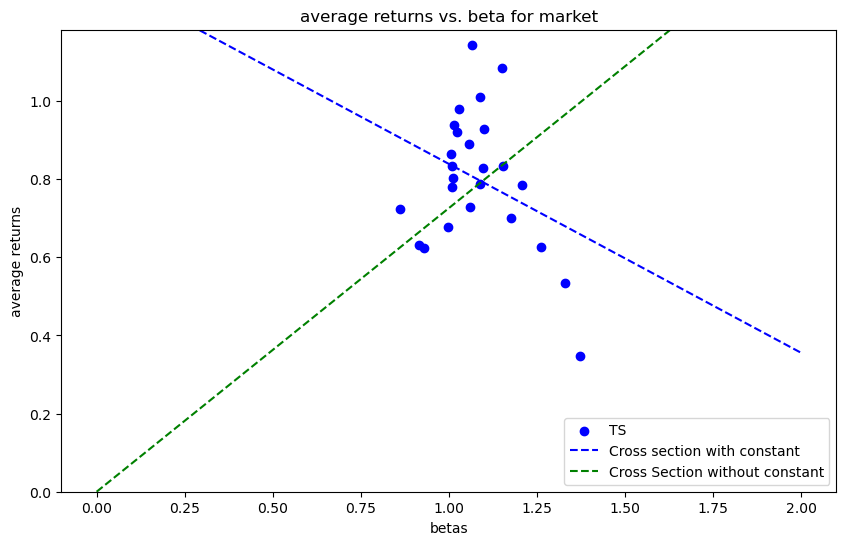

In [196]:
plt.figure(figsize=(10,6))

# Scatter Plot for Test Assets and Factors
plt.scatter(df1['beta mkt'], portfolio_25.mean(), c='b', label='TS')

# Plotting the Fitted Lines
x = np.linspace(0, 2, 100)
plt.ylim(bottom=0)

plt.plot(x,float(cross_with_constant_lambda_df['lambda_0_hat'])+ float(cross_with_constant_lambda_df['lambda_mkt'])*x, 'b--', label='Cross section with constant')
plt.plot(x,float(cross_without_constant_lambda_df['lambda_mkt'])*x, 'g--', label='Cross Section without constant')

plt.xlabel('betas')
plt.ylabel('average returns')
plt.title('average returns vs. beta for market')
plt.legend()
plt.show()

a) i) Patterns that high average returns are associated with high betas: No, in both cases (the whole dataset and sliced dataset), it looks like the returns: whether high or low, stay within a quite narrow range of betas and there is no clear sign that high average returns are associated with high betas.

In [197]:
# ii) 

# Extract p-values
p_val = df_lambda.loc['Mkt-RF','p-value']

# Check significance of lambda_mkt
if p_val < 0.05:
    print('The market risk premium (lambda) is statistically significant.')
else:
    print('The market risk premium (lambda) is not statistically significant.')

The market risk premium (lambda) is statistically significant.


iii)
Based on the Ch-squared test calculated in the previous parts we can reject the null hypothesis that alpha are equal to zero. Since the alpha in the time series analysis are not, CAPM doesn't hold.


iv) All the changes comes from the difference between the following values:- 

As per the time series regression-
alpha: 0.0818689377822116
beta: 1.0803663041234643

As per the cross sectional regression with a constant -
lambda_0_hat (alpha) :  1.322377454784267
lambda_hat (beta) :  -0.4834526202033337

The alpha's are higher in cross sectionsl regression as compared to time series one. The most notable change is the lambda_hat (beta) which goes from a positive value in the time-series regression to a negative value in the cross-sectional regression. risk premia (lambda values) are sensitive to model specifications.

v)

with intercept:
lambda_0_hat:  1.322377454784267
lambda_hat:  -0.4834526202033337

no intercept:
lambda_mkt:  0.7259054494926614

- Setting the intercept to zero implies that a portfolio should have zero exposures to any other factor beside market risk premium.
- Significant Difference in the market premium
- When we force the intercept to zero, the market premium estimate is more in line with the conventional theory.


# 

# CAPM Test on 1932-1962 Data

part b) 
alpha: 0.03481632525242266
beta: 1.3683170173893935

          lambda  Standard_Error of lambda    t-stat   p-value
Mkt-RF  1.084597                  0.324674  3.340571  0.000921

Test Stat: 0.25943114771107445
P Value: 1


-

In [198]:
ptf_25 = portfolio_24.dropna()

In [199]:
ff3n = ff3raw.dropna()

In [200]:
ptf_25['Date'] = ptf_25['Date'].astype(str)
ptf_25['Date'] = ptf_25['Date'].str[:4] + '-' + ptf_25['Date'].str[4:6]
ptf_25 = ptf_25.set_index('Date')
ptf_25 = ptf_25[(ptf_25.index >= "1932-01") & (ptf_25.index <= "1962-12")]

ff3n = ff3raw.dropna()
ff3n['Date'] = ff3n['Date'].astype(str)
ff3n['Date'] = ff3n['Date'].str[:4] + '-' + ff3n['Date'].str[4:6]
ff3n = ff3n.set_index('Date')
ff3n = ff3n[(ff3n.index >= "1932-01") & (ff3n.index <= "1962-12")]
chosen_columns = ['RF', 'Mkt-RF']
ff3n = ff3n[chosen_columns]
ff3n = pd.DataFrame(ff3n)

ptf_25 = ptf_25.sub(ff3n['RF'], axis=0)


In [201]:
# Done with data cleaning

-

a) estimated alpha and beta

In [202]:
# Define columns and corresponding index in results.params and results.bse
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1n = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in ptf_25.columns:
    # Ensure X (independent variables) is numeric
    X = sm.add_constant(ff3n.iloc[:, 1:])
    Y = ptf_25[name]

    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns:
        df1n.loc[name, col] = float(results.params[idx])

# Print the resulting DataFrame
print("alpha:", df1n['alpha'].mean())
print("beta:", df1n['beta mkt'].mean())

alpha: 0.034204840454833844
beta: 1.368671760851617


In [203]:
# alpha and beta are correct

b) estimated lambda

In [204]:
# Estimate lambda (lambda is )

# Initializing DataFrame
df_lambda = pd.DataFrame(columns=['lambda', 'Standard_Error of lambda', 't-stat', 'p-value'])

# Iterate over x in ff3 Dataset
for x in ff3n.columns[1:]: # excluding the last column whcih is risk-free rate
    x_len = ff3n[x]
    lambda_mean = x_len.mean()
    se_lambda = x_len.std() / np.sqrt(len(x_len))
    t_stat = lambda_mean / se_lambda
    
    # Getting the p-value
    # Assuming a two-tailed test, hence multiplying by 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(x_len)-1))
    
    # Assigning values to the DataFrame in one line
    df_lambda.loc[x] = [lambda_mean, se_lambda, t_stat, p_value]

# Print the resulting DataFrame
print(df_lambda.iloc[:1, ])

          lambda  Standard_Error of lambda    t-stat   p-value
Mkt-RF  1.084597                  0.324674  3.340571  0.000921


part d) Chi Sq test, T Stat, Critical Value, P Value

In [205]:
# Define columns and corresponding index in results.params and results.bse
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in ptf_25.columns:
    # Ensure X (independent variables) is numeric
    X = sm.add_constant(ff3n['Mkt-RF'])
    Y = ptf_25[name]

    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns:
        df1.loc[name, col] = float(results.params[idx])

# Number of observations
T = len(ff3n['Mkt-RF'])

# vector f (lambdas)  1*1
f = np.array([df_lambda['lambda']['Mkt-RF']])

# covariance matrix f (1x1 for CAPM, which is variance in this case)
factor_cov_mat = np.array([[ff3n['Mkt-RF'].var()]])

# alpha 25*1
alpha_vector = np.array(df1['alpha'])

# covariance matrix of residuals
residuals_df = pd.DataFrame(index=ff3n.index, columns=df1.index.tolist())
for portfolio in residuals_df.columns:
    alpha = df1.loc[portfolio, 'alpha']
    beta_mkt = df1.loc[portfolio, 'beta mkt']
    
    expected_return = alpha + beta_mkt *ff3n['Mkt-RF']
    residuals_df[portfolio] = ptf_25[portfolio] - expected_return

residuals_cov_matrix = residuals_df.cov().values

# calculate test statistics
test_statistic_2 = T * (1 / (1 + f.T @ np.linalg.inv(factor_cov_mat) @ f)) * \
                    alpha_vector.T @ np.linalg.inv(residuals_cov_matrix) @ alpha_vector

print(test_statistic_2)

40.99072393153132


In [206]:
# T Stat is correct (41)

In [207]:
# the 5% critical value
# N is the number of degrees of freedom
print(critical_value)

# T is the computed test statistic
p_value = 1 - stats.chi2.cdf(test_statistic_2, df=N)
print(p_value)
# the root mean square
rms_alpha = np.sqrt(np.mean(df1n['alpha']**2))
print(rms_alpha)

37.65248413348277
0.023008910185441267
0.21485615473836273


In [208]:
# P Value is correct

# Regressions with/without constants

In [212]:
# cross section with constant

#f1['alpha'] = pd.to_numeric(df1['alpha'], errors='coerce')
df1n['beta mkt'] = pd.to_numeric(df1n['beta mkt'], errors='coerce')

X = sm.add_constant(df1n[['beta mkt']])
Y = ptf_25.mean()
model = sm.OLS(Y, X)
results = model.fit()
results.params

# i)Estimates λˆ0 λˆ
lambda_0_hatn = results.params[0]
lambda_mktn = results.params[1]
print('lambda_0_hat: ',lambda_0_hatn)
print('lambda_hat: ',lambda_mktn)

cross_with_constant_lambda_dfn = pd.DataFrame({'lambda_0_hat':lambda_0_hatn,'lambda_mkt':lambda_mktn},index=[0])

#ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_en = pd.DataFrame()
df_part_en['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_en['pricing_error_alpha'].abs().mean()
#sst = ((Y - Y.mean())**2).sum()
#ssr = ((df_part_e['pricing_error_alpha'])**2).sum()
ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_en['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot
#r2_1 = (X.dot(results.params)).var()/Y.var()
r2_2 = 1 - (df_part_en['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_en['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

lambda_0_hat:  0.22879326937540093
lambda_hat:  0.9424235852037428
RMSE: 0.21748758116833894
MAE: 0.15099851418591725
R^2 1st: 0.5724058914152528
R^2 2nd: 0.5724058914152528
R^2 3rd: 0.5895096557586428


In [214]:
# cross section without a constant
df1n['beta mkt'] = pd.to_numeric(df1n['beta mkt'], errors='coerce')

X = df1n[['beta mkt']]  # Exclude the constant term
Y = ptf_25.mean()

model = sm.OLS(Y, X)
results = model.fit()
results.params

# i) Estimates λˆ0 λˆ
lambda_mkt = results.params['beta mkt']
print('lambda_mkt: ', lambda_mkt)

cross_without_constant_lambda_dfn = pd.DataFrame({'lambda_mkt': lambda_mkt}, index=[0])

# ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_en = pd.DataFrame()
df_part_en['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_e['pricing_error_alpha'].abs().mean()
ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_e['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot
r2_2 = 1 - (df_part_e['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_e['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

lambda_mkt:  1.1039146440264098
RMSE: 0.21748758116833894
MAE: 0.15896590055747972
R^2 1st: 0.5367798281585991
R^2 2nd: 0.5392331623855865
R^2 3rd: 0.5553086350322554


In [215]:
# R-Squared are correct

# Plots

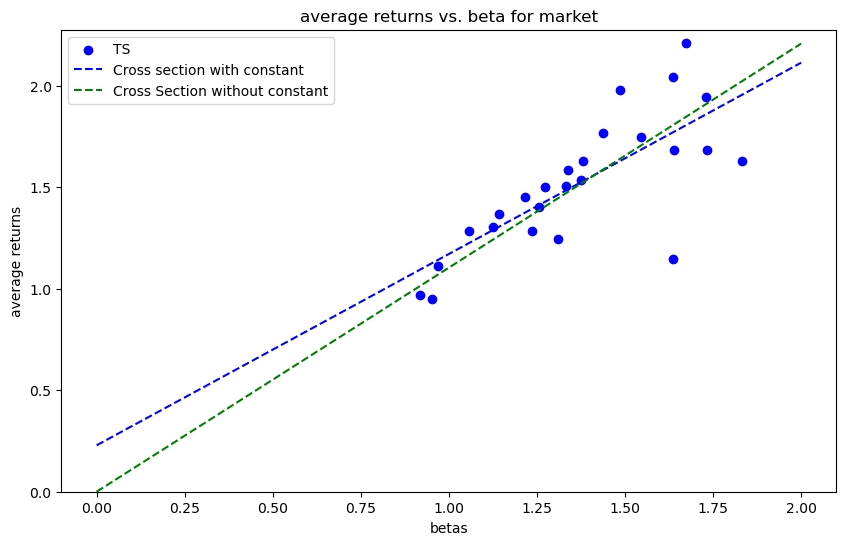

In [217]:
plt.figure(figsize=(10,6))

# Scatter Plot for Test Assets and Factors
plt.scatter(df1n['beta mkt'], ptf_25.mean(), c='b', label='TS')

# Plotting the Fitted Lines
x = np.linspace(0, 2, 100)
plt.ylim(bottom=0)

plt.plot(x,float(cross_with_constant_lambda_dfn['lambda_0_hat'])+ float(cross_with_constant_lambda_dfn['lambda_mkt'])*x, 'b--', label='Cross section with constant')
plt.plot(x,float(cross_without_constant_lambda_dfn['lambda_mkt'])*x, 'g--', label='Cross Section without constant')

plt.xlabel('betas')
plt.ylabel('average returns')
plt.title('average returns vs. beta for market')
plt.legend()
plt.show()

As we can see from the above graph that it fits quite well as compared to the earlier graphs. Here CAMP holds, as we can see there is a positive relation between the average returns and the betas which is consistent with the CAPM.

# 

# 

# Ignore Anything after this

In [ ]:
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in portfolio_25.columns:
    X = sm.add_constant(ff3)  # Directly exclude last column of ff_factors and add constant
    Y = portfolio_25[name]
    
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns[:4]:
        df1.loc[name, col] = float(results.params[idx])

# Print the resulting DataFrame
print(df1)

# Question A) Part 1: Mean Returns

In [ ]:
# define the mean_returns function and apply it into the portfolio_25 dataset to caculate mean returns

def mean_returns(portfolio_25):
    
    # Define columns and index names
    columns = ['Low-BEME', 2, 3, 4, 'High-BEME']
    index = ['Small', 2, 3, 4, 'Large']
    
    # Initialize the DataFrame with predefined column and index names
    monthly_mean_returns = pd.DataFrame(columns=columns, index=index)
    
    for SMB in range(5):
        for HML in range(5):
            # Calculate the mean of the corresponding slice of the input DataFrame
            monthly_mean_returns.iloc[SMB, HML] = portfolio_25.iloc[:, HML + SMB * 5].mean()
    
    return monthly_mean_returns

# Call the function with the 'portfolios' DataFrame
mean_returns(portfolio_25)

### Question A Part b: Run OLS time-series regressions to find parameter estimates of alpha and beta

In [ ]:
ff3['Mkt-RF'] = ff3['Mkt-RF'].astype(float)
ff3['SMB'] = ff3['SMB'].astype(float)
ff3['HML'] = ff3['HML'].astype(float)

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Define columns and corresponding index in results.params and results.bse
columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
    ('beta SMB', 2), 
    ('beta HML', 3), 
]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in portfolio_25.columns:
    # Ensure X (independent variables) is numeric
    X = sm.add_constant(ff3.iloc[:, :-1])
    Y = portfolio_25[name]

    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns:
        df1.loc[name, col] = float(results.params[idx])

# Print the resulting DataFrame
print("alpha:", df1['alpha'].mean())
print("beta:", df1['beta mkt'].mean())

In [ ]:
# Estimate lambda

# Initializing DataFrame
df_lambda = pd.DataFrame(columns=['lambda', 'Standard_Error of lambda', 't-stat', 'p-value'])

# Iterate over x in ff3 Dataset
for x in ff3.columns[:-1]: # excluding the last column whcih is risk-free rate
    x_len = ff3[x]
    lambda_mean = x_len.mean()
    se_lambda = x_len.std() / np.sqrt(len(x_len))
    t_stat = lambda_mean / se_lambda
    
    # Getting the p-value
    # Assuming a two-tailed test, hence multiplying by 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(x_len)-1))
    
    # Assigning values to the DataFrame in one line
    df_lambda.loc[x] = [lambda_mean, se_lambda, t_stat, p_value]

# Print the resulting DataFrame
print(df_lambda.iloc[:1, ])

### Question 1 Part C: Find the standard error of estimated alpha,and beta

In [ ]:
# Define columns and corresponding index in results.params and results.bse
columns1 = [
    ('Standard_Error alpha', 0), 
    ('Standard_Error beta mkt', 1), 
    ('Standard_Error beta SMB', 2), 
    ('Standard_Error beta HML', 3),
]

# Initialize DataFrame

df_se = pd.DataFrame(columns=[col[0] for col in columns1])

# Iterate over portfolios' columns and fit model for each
for name in portfolio_25.columns:
    X = sm.add_constant(ff3.iloc[:, :-1])  # Directly exclude last column of ff_factors which is the risk free rate column and add constant
    Y = portfolio_25[name]
    
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns1[:4]:
        df_se.loc[name, col] = results.params[idx]

# Print the resulting DataFrame
print(df_se)

In [ ]:
print("mean alpha se:", df_se['Standard_Error alpha'].mean())
print("mean beta se:", df_se['Standard_Error beta mkt'].mean())

### Problem 1 Part D

In [ ]:
#（d）
# number of months
T = len(ff3['HML'])

# vector f (lambdas)  3*1
f = np.array(df_lambda['lambda'])

# covariance matrix f
factor_cov_mat = np.cov(ff3.iloc[:, :-1],rowvar=False)

# alpha 25*1
alpha_vector = np.array(df1['alpha'])

# covariance matrix of residuals
residuals_df = pd.DataFrame(columns=df1.index.tolist())
for portfolio in residuals_df.columns:
    alpha = df1.loc[portfolio,'alpha']
    beta_mkt = df1.loc[portfolio,'beta mkt'] 
    beta_SMB = df1.loc[portfolio,'beta SMB']
    beta_HML = df1.loc[portfolio,'beta HML']
    residuals_df[portfolio] = portfolio_25[portfolio] - alpha - beta_mkt*ff3['Mkt-RF'] - \
                            beta_SMB*ff3['SMB'] - beta_HML*ff3['HML']    
residuals_cov_matrix = np.cov(residuals_df,rowvar=False)

#calculate test statistics
test_statistic = T*(1/(1+f.T.dot(np.linalg.inv(factor_cov_mat)).dot(f)))* \
                    alpha_vector.dot(np.linalg.inv(residuals_cov_matrix)).dot(alpha_vector.T)
test_statistic

In [ ]:
# the 5% critical value
# N is the number of degrees of freedom
N=3
critical_value = stats.chi2.ppf(0.95, df=N)
critical_value

In [ ]:
# T is the computed test statistic
p_value = 1 - stats.chi2.cdf(test_statistic, df=N)
p_value

In [ ]:
# the root mean square
rms_alpha = np.sqrt(np.mean(df1['alpha']**2))
rms_alpha

In [ ]:
average_absolute_alphas = np.mean(np.abs(df1['alpha']))
average_absolute_alphas

### Problem 1 Part E

In [ ]:
#cross sectional regression with a constant
#f1['alpha'] = pd.to_numeric(df1['alpha'], errors='coerce')
df1['beta mkt'] = pd.to_numeric(df1['beta mkt'], errors='coerce')
df1['beta SMB'] = pd.to_numeric(df1['beta SMB'], errors='coerce')
df1['beta HML'] = pd.to_numeric(df1['beta HML'], errors='coerce')

X = sm.add_constant(df1[['beta mkt','beta SMB','beta HML']])
Y = portfolio_25.mean()
model = sm.OLS(Y, X)
results = model.fit()
results.params

In [ ]:
# i)Estimates λˆ0 λˆ
lambda_0_hat = results.params[0]
lambda_mkt = results.params[1]
lambda_SMB = results.params[2]
lambda_HML = results.params[3]
print('lambda_0_hat: ',lambda_0_hat)
print('lambda_hat: ',lambda_mkt,lambda_SMB,lambda_HML)

In [ ]:
cross_with_constant_lambda_df = pd.DataFrame({'lambda_0_hat':lambda_0_hat,'lambda_mkt':lambda_mkt,'lambda_SMB':lambda_SMB,'lambda_HML':lambda_HML},index=[0])

In [ ]:
#ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_e = pd.DataFrame()
df_part_e['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_e['pricing_error_alpha'].abs().mean()
#sst = ((Y - Y.mean())**2).sum()
#ssr = ((df_part_e['pricing_error_alpha'])**2).sum()
ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_e['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot
#r2_1 = (X.dot(results.params)).var()/Y.var()
r2_2 = 1 - (df_part_e['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_e['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

In [ ]:
##  Run it with no constant
df1['beta mkt'] = pd.to_numeric(df1['beta mkt'], errors='coerce')
df1['beta SMB'] = pd.to_numeric(df1['beta SMB'], errors='coerce')
df1['beta HML'] = pd.to_numeric(df1['beta HML'], errors='coerce')

columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
    ('beta SMB', 2), 
    ('beta HML', 3), 
]
# Iterate over portfolios' columns and fit model for each

X = sm.add_constant(ff3.iloc[:, :-1])  # Directly exclude last column of ff_factors and add constant
#Y = ff3['RF']R^2 1st: 0.6165136172478135


model = sm.OLS(Y, X, missing='drop')
results = model.fit()

# Assign computed values to the DataFrame
for col, idx in columns[:4]:
    df1.loc['RF', col] = float(results.params[idx])


X = df1[['beta mkt','beta SMB','beta HML']]
Y = portfolio_25.mean()
Y = pd.concat([Y, pd.Series([ff3['RF'].mean()], index=['RF'])])

model = sm.OLS(Y, X)
results = model.fit()
results.params



In [ ]:
# i) Collect estimates ˆα, λ
lambda_mkt = results.params[0]
lambda_SMB = results.params[1]
lambda_HML = results.params[2]
print('lambda_hat: ',lambda_mkt,lambda_SMB,lambda_HML)

In [ ]:
cross_without_constant_lambda_df = pd.DataFrame({'lambda_mkt':lambda_mkt,'lambda_SMB':lambda_SMB,'lambda_HML':lambda_HML},index=[0])

In [ ]:
df_part_e2 = pd.DataFrame()
df_part_e2['predicted_ret'] = results.predict(X)
df_part_e2['pricing_error_alpha'] = Y - df_part_e2['predicted_ret']
#df_part_e2['pricing_error_alpha']

In [ ]:
#ii) Compute standard errors of λˆ and ˆα with traditional iid formulas.
se_lambda_mkt = results.bse[0]
se_lambda_SMB = results.bse[1]
se_lambda_HML = results.bse[2]
print('lambda_hat: ',se_lambda_mkt,se_lambda_SMB,se_lambda_HML)

In [ ]:
residuals = results.resid
se_alpha = np.sqrt(np.sum(residuals**2)/results.df_resid)
se_alpha

In [ ]:
#iii) Compute the asymptotic Chi-squared test with statistic, 5% critical value, p-value, for iid formulas
#alpha hat 26*1
alpha_hat = np.array(df_part_e2['pricing_error_alpha'])
T = len(ff3['HML'])
# beta vector 26*3
beta_vector = np.array(df1[['beta mkt','beta SMB','beta HML']])
# lambda vector 3*1
lambda_vector = np.array([[lambda_mkt],[lambda_SMB],[lambda_HML]])
lambda_vector
# covariance matrix f 3*3
factor_cov_mat = np.cov(ff3.iloc[:, :-1],rowvar=False)
# residuals_cov_matrix ()
portfolio_26 = portfolio_25
portfolio_26['RF'] = ff3['RF']
residuals_df_1e = portfolio_26.sub(np.array(beta_vector@lambda_vector).T,axis=1)
residuals_cov_matrix_1e = residuals_df_1e.cov()


In [ ]:
# term after T
expression_with_beta = np.identity(len(beta_vector)) - beta_vector@\
                        np.linalg.inv(beta_vector.T@beta_vector)@(beta_vector.T)


# cov(alpha_hat)
cov_alpha_hat = (1/T)*(expression_with_beta)@residuals_cov_matrix_1e@(expression_with_beta)*\
                (1+lambda_vector.T@np.linalg.inv(factor_cov_mat)@lambda_vector).item()
cov_alpha_hat

# test_stat
test_statistic_1e = alpha_hat.T@np.linalg.inv(cov_alpha_hat)@alpha_hat
test_statistic_1e

In [ ]:
df = 3
critical_value = stats.chi2.ppf(1 - 0.05, df)
p_value = stats.chi2.sf(test_statistic_1e, df)
print("Test Statistic:", test_statistic_1e)
print("Critical Value at 5% Significance Level:", critical_value)
print("p-value:", p_value)

In [ ]:
#iv)
#Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_1e4 = pd.DataFrame()
df_part_1e4['pricing_error_alpha'] = Y - X.dot(results.params)

rmse = np.sqrt(((df_part_e['pricing_error_alpha'])**2).mean())
mae = df_part_e['pricing_error_alpha'].abs().mean()
# sst = ((Y - Y.mean())**2).sum()
# ssr = ((df_part_e['pricing_error_alpha'])**2).sum()


ss_tot = ((Y - Y.mean())**2).sum()
ss_res = ((df_part_1e4['pricing_error_alpha'])**2).sum()

r2_1 = 1 - ss_res/ss_tot

#r2_1 = (X.dot(results.params)).var()/Y.var()
r2_2 = 1 - (df_part_1e4['pricing_error_alpha']).var()/Y.var()
r2_3 = 1 -((df_part_1e4['pricing_error_alpha'])**2).mean()/Y.var()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 1st: {r2_1}")
print(f"R^2 2nd: {r2_2}")
print(f"R^2 3rd: {r2_3}")

### Problem 1 (f)

In [ ]:
import matplotlib.pyplot as plt
# method 1 Time Series
# method 2 Cross Sectional with Constant
# method 3 Cross Sectional without Constant

In [ ]:
plt.figure(figsize=(10,6))

# Scatter Plot for Test Assets and Factors
plt.scatter(df1['beta mkt'], portfolio_26.mean(), c='b', label='TS')

# Plotting the Fitted Lines
x = np.linspace(0, 2, 100)
plt.ylim(bottom=0)

plt.plot(x,float(cross_with_constant_lambda_df['lambda_0_hat'])+float(cross_with_constant_lambda_df['lambda_mkt'])*x, 'b--', label='Cross section with constant')
plt.plot(x,float(cross_without_constant_lambda_df['lambda_mkt'])*x, 'g--', label='Cross Section without constant')


plt.xlabel('betas')
plt.ylabel('average returns')
plt.title('average returns vs. beta for market')
plt.legend()
plt.show()

# f) a) i)

Patterns that high average returns are associated with high betas: No, in both cases, it looks like the returns, wether high or low, stay within a quite narrow range of betas, between 0.9 and 1.1, and there is no clear sign that high average returns are associated with high betas

# f) a) ii)

In [ ]:
# Extract p-values
p_values = results.pvalues

# Check significance of lambda_mkt
if p_values['beta mkt'] < 0.05:
    print('The market premium lambda is statistically significant.')
else:
    print('The market premium lambda is not statistically significant.')

# f) a) iii)

- p-value: The p-value is 0.0, which is less than the significance level of 0.05.
- Critical Value at 5% Significance Level: 7.81 is the chi-squared value for which only 5% of the distribution lies to its right when there are 3 degrees of freedom.
- The average of the absolute values of the alpha estimates is 0.0943. A value significantly different from 0 suggests that there are systematic patterns in returns that the market factor alone (as per CAPM) doesn't capture.
- Given the results, The chi-squared test indicates that the CAPM is rejected, and the non-zero average of absolute alphas suggests that the CAPM is rejected


# f) a) iv)

How does the estimate of ˆλ and the ˆα in the cross sectional regression with a free constant differ from that of the time-series regression? Track down where this difference
comes from there is an important lesson here. (Hint: look at the expected return vs beta graphs)

The addition of a constant in the cross-sectional regression changes the estimates of the lambdas. The most notable change is the λmkt which goes from a positive value in the time-series regression to a negative value in the cross-sectional regression. risk premia (lambda values) are sensitive to model specifications (diff between add constant and without constant)


                                               

# f) a) v)

How does the estimate of ˆλ when we force the intercept to zero and price the factors compare?

with intercept:
const       1.363281
beta mkt   -0.689089
beta SMB    0.071590
beta HML    0.317528

no intercept:
beta mkt    0.626051
beta SMB    0.088736
beta HML    0.347640

" 
- Setting the intercept to zero implies that a portfolio with zero exposures to all the factors should have an expected return of zero.
- Significant Difference in the market premium
- When we force the intercept to zero, the market premium estimate is more in line with the conventional theory.

# f) b) Reproduce with data from 1932 to 1962

In [ ]:
ptf62 = pd.read_csv(file_path)
ptf62 = ptf62.dropna()
ptf62['Date'] = ptf62['Date'].astype(int)
ptf62 = ptf62[(ptf62['Date'] >= 193201) & (ptf62['Date'] <= 196212)]
ptf62['Date'] = ptf62['Date'].astype(str)
ptf62['Date'] = ptf62['Date'].str[:4] + '-' + ptf62['Date'].str[4:6]
ptf62 = ptf62.set_index('Date')

In [ ]:
ffnew = pd.read_csv(files_2)
ffnew = ffnew.dropna()
ffnew['Date'] = ffnew['Date'].astype(int)
ffnew = ffnew[(ffnew['Date'] >= 193201) & (ffnew['Date'] <= 196212)]
ffnew['Date'] = ffnew['Date'].astype(str)
ffnew['Date'] = ffnew['Date'].str[:4] + '-' + ffnew['Date'].str[4:6]
ffnew = ffnew.set_index('Date')

In [ ]:
ptf62 = ptf62.loc[~ptf62.index.duplicated(keep='first')]
# Convert portfolio_25 to numeric
ptf62 = ptf62.apply(pd.to_numeric, errors='coerce')
# Convert the RF column from ff3 to numeric
ffnew['RF'] = pd.to_numeric(ffnew['RF'], errors='coerce')
ptf62 = ptf62.sub(ffnew['RF'], axis=0)

In [ ]:
# done with data cleaning

In [ ]:
# Define the mean_returns function and apply it into the ptf62 dataset to calculate mean returns
def mean_returns(ptf62):
    
    # Define columns and index names
    columns = ['Low-BEME', 2, 3, 4, 'High-BEME']
    index = ['Small', 2, 3, 4, 'Large']
    
    # Initialize the DataFrame with predefined column and index names
    monthly_mean_returns = pd.DataFrame(columns=columns, index=index)
    
    for SMB in range(5):
        for HML in range(5):
            # Calculate the mean of the corresponding slice of the input DataFrame
            monthly_mean_returns.iloc[SMB, HML] = ptf62.iloc[:, HML + SMB * 5].mean()
    
    return monthly_mean_returns

# Call the function with the 'ptf62' DataFrame
mean_returns(ptf62)


OLS timeseries regressions to find parameter estimates of alpha and beta

In [ ]:
ffnew['Mkt-RF'] = ffnew['Mkt-RF'].astype(float)
ffnew['SMB'] = ffnew['SMB'].astype(float)
ffnew['HML'] = ffnew['HML'].astype(float)

# Define columns and corresponding index in results.params and results.bse
columns = [('alpha', 0), ('beta mkt', 1), ('beta SMB', 2), ('beta HML', 3), ]

# Initialize DataFrame with columns named after the first elements of the tuples in the columns list
n_df1 = pd.DataFrame(columns=[col[0] for col in columns])

# Iterate over portfolios' columns and fit model for each
for name in ptf62.columns:
    X = sm.add_constant(ffnew.iloc[:, :-1])  # Directly exclude last column of ff_factors and add constant
    Y = ptf62[name]
    
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()
    
    # Assign computed values to the DataFrame
    for col, idx in columns[:4]:
        n_df1.loc[name, col] = float(results.params[idx])

# Print the resulting DataFrame
# print(n_df1)

In [ ]:
# Estimate lambda

# Initializing DataFrame
n_df_lambda = pd.DataFrame(columns=['lambda', 'Standard_Error of lambda', 't-stat', 'p-value'])

# Iterate over x in ffnew Dataset
for x in ffnew.columns[:-1]:  # excluding the last column which is risk-free rate
    x_len = ffnew[x]
    lambda_mean = x_len.mean()
    se_lambda = x_len.std() / np.sqrt(len(x_len))
    t_stat = lambda_mean / se_lambda
    
    # Getting the p-value
    # Assuming a two-tailed test, hence multiplying by 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(x_len)-1))
    
    # Assigning values to the DataFrame in one line
    n_df_lambda.loc[x] = [lambda_mean, se_lambda, t_stat, p_value]

# Print the resulting DataFrame
print(n_df_lambda)

# c) standard error of alpha and beta

In [ ]:
# Define columns and corresponding index in results.params and results.bse
columns1 = [('Standard_Error alpha', 0), ('Standard_Error beta mkt', 1), ('Standard_Error beta SMB', 2), ('Standard_Error beta HML', 3),]

# Initialize DataFrame
n_df_se = pd.DataFrame(columns=[col[0] for col in columns1])

# Iterate over portfolios' columns and fit model for each
for name in ptf62.columns:
    X = sm.add_constant(ffnew.iloc[:, :-1])  # Exclude last column (risk-free rate) and add constant
    Y = ptf62[name]    
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()    
    # Assign computed values to the DataFrame
    for col, idx in columns1[:4]:
        n_df_se.loc[name, col] = results.bse[idx]

# Print the resulting DataFrame
# print(n_df_se)

# d) 

In [ ]:
# Number of months
T = len(ffnew['HML'])

# Vector f (lambdas)  3*1
f = np.array(n_df_lambda['lambda'])

# Covariance matrix f
factor_cov_mat = np.cov(ffnew.iloc[:, :-1], rowvar=False)

# Alpha 25*1
alpha_vector = np.array(n_df1['alpha'])

# Covariance matrix of residuals
residuals_df_new = pd.DataFrame(columns=n_df1.index.tolist())
for portfolio in residuals_df_new.columns:
    alpha = n_df1.loc[portfolio,'alpha']
    beta_mkt = n_df1.loc[portfolio,'beta mkt'] 
    beta_SMB = n_df1.loc[portfolio,'beta SMB']
    beta_HML = n_df1.loc[portfolio,'beta HML']
    residuals_df_new[portfolio] = ptf62[portfolio] - alpha - beta_mkt*ffnew['Mkt-RF'] - \
                            beta_SMB*ffnew['SMB'] - beta_HML*ffnew['HML']    
residuals_cov_matrix = np.cov(residuals_df_new, rowvar=False)

In [ ]:
# Calculate test statistics
test_statistic_new = T * (1 / (1 + f.T.dot(np.linalg.inv(factor_cov_mat)).dot(f))) * \
                    alpha_vector.dot(np.linalg.inv(residuals_cov_matrix)).dot(alpha_vector.T)
print("Test Statistic:", test_statistic_new)


In [ ]:
p_value_new = 1 - stats.chi2.cdf(test_statistic_new, df=N)
print("P-Value:", p_value_new)

In [ ]:
rms_alpha_new = np.sqrt(np.mean(n_df1['alpha']**2))
print("RMS Alpha:", rms_alpha_new)

In [ ]:
average_absolute_alphas_new = np.mean(np.abs(n_df1['alpha']))
print("Average Absolute Alphas:", average_absolute_alphas_new)

# e) Cross-sectional regression with a constant

In [ ]:
n_df1['beta mkt'] = pd.to_numeric(n_df1['beta mkt'], errors='coerce')
n_df1['beta SMB'] = pd.to_numeric(n_df1['beta SMB'], errors='coerce')
n_df1['beta HML'] = pd.to_numeric(n_df1['beta HML'], errors='coerce')

X = sm.add_constant(n_df1[['beta mkt', 'beta SMB', 'beta HML']])
Y = ptf62.mean()
model = sm.OLS(Y, X)
results = model.fit()
results.params

In [ ]:
# i) Estimates λˆ0 λˆ
lambda_0_hat_new = results.params[0]
lambda_mkt_new = results.params[1]
lambda_SMB_new = results.params[2]
lambda_HML_new = results.params[3]
print('lambda_0_hat:', lambda_0_hat_new)
print('lambda_hat:', lambda_mkt_new, lambda_SMB_new, lambda_HML_new)

In [ ]:
cross_with_constant_lambda_df = pd.DataFrame({
    'lambda_0_hat': lambda_0_hat_new,
    'lambda_mkt': lambda_mkt_new,
    'lambda_SMB': lambda_SMB_new,
    'lambda_HML': lambda_HML_new
}, index=[0])

# ii) Root mean square and mean absolute pricing errors ˆα, and the R2 of actual vs. predicted mean returns
df_part_e = pd.DataFrame()
df_part_e['pricing_error_alpha'] = Y - X.dot(results.params)

rmse_new = np.sqrt((df_part_e['pricing_error_alpha']**2).mean())
mae_new = df_part_e['pricing_error_alpha'].abs().mean()
sst_new = ((Y - Y.mean())**2).sum()
ssr_new = (df_part_e['pricing_error_alpha']**2).sum()

r2_1_new = (X.dot(results.params)).var() / Y.var()
r2_2_new = 1 - df_part_e['pricing_error_alpha'].var() / Y.var()
r2_3_new = 1 - (df_part_e['pricing_error_alpha']**2).mean() / Y.var()

print(f"RMSE: {rmse_new}")
print(f"MAE: {mae_new}")
print(f"R^2 1st: {r2_1_new}")
print(f"R^2 2nd: {r2_2_new}")
print(f"R^2 3rd: {r2_3_new}")

# The two R Squared are same, but should be different

In [ ]:
# Without constant
n_df1['beta mkt'] = pd.to_numeric(n_df1['beta mkt'], errors='coerce')
n_df1['beta SMB'] = pd.to_numeric(n_df1['beta SMB'], errors='coerce')
n_df1['beta HML'] = pd.to_numeric(n_df1['beta HML'], errors='coerce')

columns = [
    ('alpha', 0), 
    ('beta mkt', 1), 
    ('beta SMB', 2), 
    ('beta HML', 3), 
]

X = sm.add_constant(ffnew.iloc[:, :-1])  # Directly exclude last column of ff_factors and add constant
Y = ffnew['RF']

model = sm.OLS(Y, X, missing='drop')
results = model.fit()

# Assign computed values to the DataFrame
for col, idx in columns[:4]:
    n_df1.loc['RF', col] = float(results.params[idx])

X = n_df1[['beta mkt','beta SMB','beta HML']]
Y = ptf62.mean()
Y = pd.concat([Y, pd.Series([ffnew['RF'].mean()], index=['RF'])])

model = sm.OLS(Y, X)
results = model.fit()
results.params